In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix


#1. Upload The Dataset

In [2]:
!unzip "/content/csc462-connect-4.zip" -d "/content/"

Archive:  /content/csc462-connect-4.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      
  inflating: /content/val.csv        


In [3]:
testdata = pd.read_csv("/content/test.csv")
traindata = pd.read_csv("/content/train.csv")
valdata = pd.read_csv("/content/val.csv")

In [4]:
traindata.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p35,p36,p37,p38,p39,p40,p41,p42,turn,label_move_col
0,0,1,-1,1,-1,0,1,0,1,-1,...,0,0,0,0,0,0,0,0,1,1
1,0,-1,-1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-1,1
2,0,1,-1,1,0,0,1,0,0,-1,...,0,0,0,0,0,0,0,0,-1,2
3,1,0,0,0,-1,1,1,-1,0,0,...,0,0,0,0,0,0,0,0,-1,3
4,1,1,-1,-1,-1,1,-1,1,0,0,...,1,-1,0,0,0,0,0,1,-1,4


In [5]:
traindata.shape

(49993, 44)

In [6]:
traindata['turn'].nunique()

2

#2. Preprocessing

## split

In [7]:
train_x = traindata.drop(columns=['label_move_col'])
train_x = train_x.replace({-1: 2})
train_y = traindata['label_move_col']
val_x = valdata.drop(columns=['label_move_col'])
val_x = val_x.replace({-1: 2})
val_y = valdata['label_move_col']
test_x = testdata.drop(columns=['id'])
test_x = test_x.replace({-1: 2})

In [8]:
traintensor_x = torch.tensor(train_x.values, dtype=torch.int64)
traintensor_y = torch.tensor(train_y.values, dtype=torch.long)
valtensor_x = torch.tensor(val_x.values, dtype=torch.int64)
valtensor_y = torch.tensor(val_y.values, dtype=torch.long)
testtensor_x = torch.tensor(test_x.values, dtype=torch.int64)


## convert to tensor and split

## build custom dataset class.
why? to handle preprocessing to transforms each game state into 2D representation, and to make sure the turn column is included within the state by adding it as extra channel. Also, this approach helps later in training process when loading the data to model for training.

In [9]:
def count_open(board, player):
    open_three_map = torch.zeros_like(board, dtype=torch.float32)
    open_two_map = torch.zeros_like(board, dtype=torch.float32)
    directions = [(0, 1),(1, 0),(1, 1),(-1, 1)]
    rows, cols = board.shape
    for dr, dc in directions:
        for r in range(rows):
            for c in range(cols):
                r_end = r + (3 * dr)
                c_end = c + (3 * dc)
                if not (0 <= r_end < rows and 0 <= c_end < cols):
                    continue
                cells = [board[r + i*dr, c + i*dc] for i in range(4)]
                cells_tensor = torch.tensor(cells)
                player_count = (cells_tensor == player).sum().item()
                empty_count = (cells_tensor == 0).sum().item()
                if player_count == 3 and empty_count == 1:
                    for i in range(4):
                        if cells[i] == 0:
                            rr = r + i*dr
                            cc = c + i*dc
                            open_three_map[rr, cc] = 1.0
                if player_count == 2 and empty_count == 2:
                    for i in range(4):
                        if cells[i] == 0:
                            rr = r + i*dr
                            cc = c + i*dc
                            open_two_map[rr, cc] = 1.0
    return open_two_map ,open_three_map

In [10]:
def precompute_open_features(X):

    N = X.shape[0]
    open2p_maps = torch.zeros((N, 6, 7), dtype=torch.float32)
    open3p_maps = torch.zeros((N, 6, 7), dtype=torch.float32)
    open2n_maps = torch.zeros((N, 6, 7), dtype=torch.float32)
    open3n_maps = torch.zeros((N, 6, 7), dtype=torch.float32)

    for i in range(N):
        row = X[i]
        board = row[:-1].view(6, 7)
        turn = row[-1].item()
        open2p_maps[i], open3p_maps[i] = count_open(board, turn)
        opponent = -turn
        open2n_maps[i], open3n_maps[i] = count_open(board, opponent)

    return open2p_maps, open3p_maps, open2n_maps, open3n_maps

In [11]:
class Connect4Dataset(Dataset):
    def __init__(self, X, y=None):

        self.X = torch.tensor(X, dtype=torch.int64)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X[idx]


        board = row[:-1].view(6, 7)
        turn = row[-1].item() if row[-1].numel() == 1 else int(row[-1])

        #board_onehot = torch.nn.functional.one_hot(board, num_classes=3).float()
        #board_onehot = board_onehot.view(6,7,3).permute(2,0,1)
        #turn_channel = torch.full((1,6,7), float(turn.detach()), dtype=board_onehot.dtype)
        #board_with_turn = torch.cat([board_onehot, turn_channel], dim=0)
        player1 = (board == 1).float().unsqueeze(0)   # (1,6,7)
        player2 = (board == -1).float().unsqueeze(0)
        empty   = (board == 0).float().unsqueeze(0)

        open2p, open3p = count_open(board, turn) #count open opportunity for the current player
        open2n, open3n = count_open(board, -turn) #count open opportunity for the


        turn_channel = torch.full((1, 6, 7), 1.0 if turn == 1 else 0.0)
        board_input = torch.cat([player1, player2, empty, turn_channel], dim=0)



        if self.y is not None:
            label = self.y[idx]
            return board_input, label
        else:
            return board_input


In [12]:
class Connect4Dataset1(Dataset):
    def __init__(self, X, y=None, open2p=None, open3p=None, open2n=None, open3n=None):
        self.X = torch.tensor(X, dtype=torch.int64)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None
        self.open2p = open2p
        self.open3p = open3p
        self.open2n = open2n
        self.open3n = open3n

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X[idx]
        board = row[:-1].view(6, 7)
        turn = row[-1].item() if row[-1].numel() == 1 else int(row[-1])
        normalized_board = (board + 1) / 2
        player1 = (board == 1).float().unsqueeze(0)
        player2 = (board == 0).float().unsqueeze(0)
        empty = (board == 0.5).float().unsqueeze(0)

        open2p = self.open2p[idx].unsqueeze(0)
        open3p = self.open3p[idx].unsqueeze(0)
        open2n = self.open2n[idx].unsqueeze(0)
        open3n = self.open3n[idx].unsqueeze(0)

        turn_channel = torch.full((1, 6, 7), 1.0 if turn == 1 else 0.0)

        board_input = torch.cat([player1, player2, empty, open2p, open3p, open2n, open3n, turn_channel], dim=0)

        if self.y is not None:
            label = self.y[idx]
            return board_input, label
        else:
            return board_input


#3. Load the dataset

In [13]:
def setup_dataset(X,y=None):
  open2p_maps, open3p_maps, open2n_maps, open3n_maps = precompute_open_features(X)
  dataset = Connect4Dataset1(X, y, open2p_maps, open3p_maps, open2n_maps, open3n_maps)
  return dataset


In [14]:
train_dataset = setup_dataset(traintensor_x, traintensor_y)
val_dataset = setup_dataset(valtensor_x, valtensor_y)
test_dataset = setup_dataset(testtensor_x)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipython-input-1859513733.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.int64)
/tmp/ipython-input-1859513733.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long) if y is not None else None


#4. Build the CNN model

Build the model architacture

In [15]:
class Connect4CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self._to_linear = None
        self._d_forward()

        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 7)
        )

    def _d_forward(self):

        x = torch.zeros(1, 4, 6, 7)
        x = self.conv_layers(x)
        self._to_linear = x.numel()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [16]:
class Connect4CNN1(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(6, 42, kernel_size=4, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
        )

        self._to_linear = None
        self._get_flatten_size()

        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 7),
        )

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 6, 6, 7)
            x = self.conv_layers(x)
            self._to_linear = x.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [17]:
class Connect4CNN2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(8, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self._to_linear = None
        self._get_flatten_size()

        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 64),
            nn.ReLU(),
            nn.Linear(64, 7),
        )

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 8, 6, 7)
            x = self.conv_layers(x)
            self._to_linear = x.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


training setup

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Connect4CNN2().to(device)

#criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [21]:
best_val_loss = np.inf
patience = 20
counter = 0
best_model_path = "/content/best_connect4_model.pth"
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 100

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)



    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")
    if epoch == 100:
        torch.save(model.state_dict(),"/content/100epoch_connect4_model.pth")
    if epoch == 150:
        torch.save(model.state_dict(),"/content/150epoch_connect4_model.pth")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("Validation loss improved — model saved.")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs.")
    if counter >= patience:
      print("Counter reached the patience limit. Stopping training.")
      break


Epoch [1/100] | Train Loss: 0.9742 | Val Loss: 0.8813 | Val Acc: 0.5435
Validation loss improved — model saved.
Epoch [2/100] | Train Loss: 0.8467 | Val Loss: 0.8036 | Val Acc: 0.5603
Validation loss improved — model saved.
Epoch [3/100] | Train Loss: 0.8082 | Val Loss: 0.7799 | Val Acc: 0.5638
Validation loss improved — model saved.
Epoch [4/100] | Train Loss: 0.7838 | Val Loss: 0.7711 | Val Acc: 0.5770
Validation loss improved — model saved.
Epoch [5/100] | Train Loss: 0.7653 | Val Loss: 0.7580 | Val Acc: 0.5833
Validation loss improved — model saved.
Epoch [6/100] | Train Loss: 0.7452 | Val Loss: 0.7341 | Val Acc: 0.5933
Validation loss improved — model saved.
Epoch [7/100] | Train Loss: 0.7346 | Val Loss: 0.7312 | Val Acc: 0.5942
Validation loss improved — model saved.
Epoch [8/100] | Train Loss: 0.7155 | Val Loss: 0.7079 | Val Acc: 0.5962
Validation loss improved — model saved.
Epoch [9/100] | Train Loss: 0.7075 | Val Loss: 0.7350 | Val Acc: 0.5928
No improvement for 1 epochs.
Epo

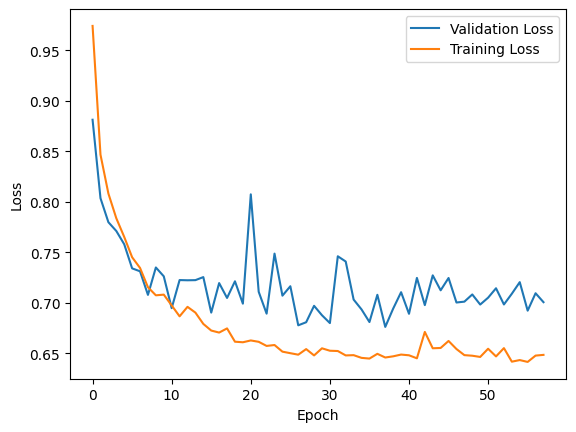

In [27]:
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

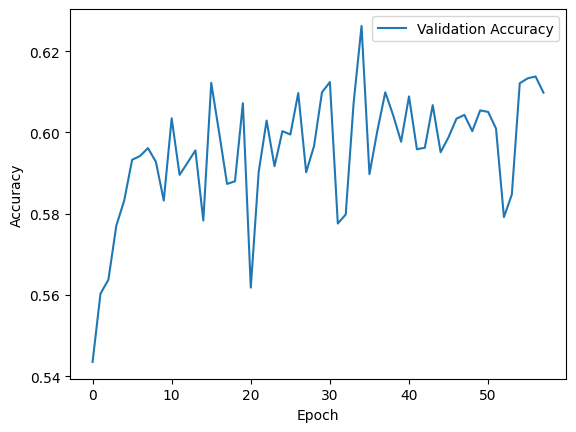

In [28]:
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Evaluation

In [29]:
best_model = Connect4CNN2().to(device)
best_model.load_state_dict(torch.load("best_connect4_model.pth"))
best_model.eval()

Connect4CNN2(
  (conv_layers): Sequential(
    (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1152, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [30]:
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        preds = torch.argmax(best_model(xb.to(device)), dim=1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.53      0.48      1450
           1       0.61      0.47      0.53       925
           2       0.63      0.55      0.59      1033
           3       0.65      0.90      0.76      3958
           4       0.67      0.48      0.56      1033
           5       0.69      0.44      0.54       925
           6       0.56      0.24      0.34      1450

    accuracy                           0.61     10774
   macro avg       0.61      0.51      0.54     10774
weighted avg       0.61      0.61      0.59     10774

[[ 766   72   73  376   53   37   73]
 [  66  433   49  290   32   26   29]
 [  70   23  567  280   27   24   42]
 [ 210   22   44 3551   30   26   75]
 [ 121   53   48  285  496   15   15]
 [  93   49   49  249   39  406   40]
 [ 440   57   75  411   58   57  352]]


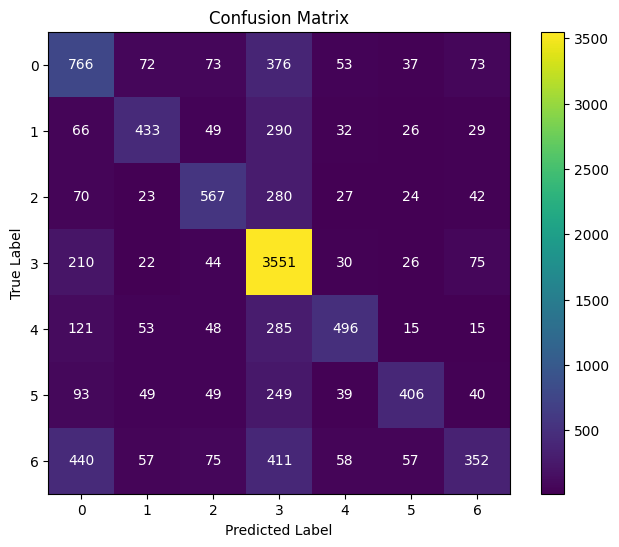

In [32]:
#confusion Matrix plt
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(7)
plt.xticks(tick_marks, np.arange(7))
plt.yticks(tick_marks, np.arange(7))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="black" if cm[i, j] > thresh else "white")

plt.show()

Save the model

In [ ]:
torch.save(best_model.state_dict(), "connect4_final.pth")
traced = torch.jit.trace(best_model, torch.randn(1, 8, 6, 7).to(device))
traced.save("connect4_model_scripted.pt")